<a href="https://colab.research.google.com/github/imnotsoumyajit/Mental-Health-Analysis/blob/master/updated_sentimental_analysis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install catboost xgboost lightgbm wordcloud textblob

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 98.7/98.7 MB 8.6 MB/s eta 0:00:00


In [2]:
import pandas as pd
import numpy as np
import string

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split, cross_val_score,GridSearchCV, RandomizedSearchCV
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score
from sklearn.pipeline import Pipeline
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier
from catboost import CatBoostClassifier

from wordcloud import WordCloud
from nltk.corpus import stopwords
from textblob import Word, TextBlob
from nltk.sentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
from nltk.stem import WordNetLemmatizer
import spacy

import matplotlib.pyplot as plt
import seaborn as sns

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

import warnings
warnings.filterwarnings("ignore")

pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)
pd.set_option('display.max_rows', 55)
pd.set_option('display.float_format', lambda x: '%.3f' % x)

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning: 
Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.

  warnings.warn(msg, FutureWarning)


In [3]:
df=pd.read_csv('/content/Combined Data.csv')
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [4]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 53043 entries, 0 to 53042
Data columns (total 3 columns):
 #   Column      Non-Null Count  Dtype 
---  ------      --------------  ----- 
 0   Unnamed: 0  53043 non-null  int64 
 1   statement   52681 non-null  object
 2   status      53043 non-null  object
dtypes: int64(1), object(2)
memory usage: 1.2+ MB


In [5]:
df['statement'] = df['statement'].fillna('')

In [6]:
df.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [7]:
df.drop(["Unnamed: 0"], axis = 1, inplace = True)

In [8]:
df["status"].unique()

array(['Anxiety', 'Normal', 'Depression', 'Suicidal', 'Stress', 'Bipolar',
       'Personality disorder'], dtype=object)

In [9]:
df[df["status"] == "Anxiety"]["statement"][1]

'trouble sleeping, confused mind, restless heart. All out of tune'

In [10]:
df["status"] = df["status"].map({'Anxiety':0, 'Normal':1, 'Depression':2, 'Suicidal':3, 'Stress':4, "Bipolar": 5, "Personality disorder": 6})

In [11]:
def clean_text(text):
    # Normalizing Case Folding
    text = text.str.lower()
    text = text.str.replace(r'[^\w\s]', '', regex = True)
    text = text.str.replace("\n" , '', regex = True)
    text = text.str.replace('\d', '', regex = True)
    text = text.str.replace(r'\[.*?\]', '', regex = True)
    text = text.str.replace(r'https?://\S+|www\.\S+', '', regex = True)
    text = text.str.replace(r'<.*?>+', '', regex = True)
    text = text.str.replace(r'\w*\d\w*', '', regex = True)
    return text

In [12]:
df["statement"] = clean_text(df["statement"])

In [13]:
def remove_stopwords(text):
    stop_words = stopwords.words('english')
    text = text.apply(lambda x: " ".join(x for x in str(x).split() if x not in stop_words))
    return text

In [14]:
import nltk
nltk.download("stopwords")
df["statement"] = remove_stopwords(df["statement"])

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


In [15]:
delete = pd.Series(' '.join(df['statement']).split()).value_counts()[-1000:]
df['statement'] = df['statement'].apply(lambda x: " ".join(x for x in x.split() if x not in delete))

In [16]:
nlp = spacy.load('en_core_web_sm')

def lemmatize_sentence(sentence):
    doc = nlp(sentence)
    return " ".join([token.lemma_ for token in doc])

In [17]:
df['statement'] = df['statement'].apply(lemmatize_sentence)

In [18]:
df.head()

,statement,status
0,oh gosh,0
1,trouble sleep confused mind restless heart tune,0
2,wrong back dear forward doubt stay restless re...,0
3,I ve shift focus something else I m still worried,0
4,I m restless restless month boy mean,0


In [19]:
df.isnull().sum()

,0
statement,0
status,0


In [20]:
y = df['status']
X = df.drop('status', axis=1)

In [21]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)

In [22]:
X_train

,statement
32560,get
22775,come awful start lose year relationship family...
44021,need inspiration hit kitchen tonight
20262,possible communicate text suicidal feel like s...
13631,literally get call wierd internet friend group...
...,...
11284,use confident cheerful person today become awk...
44732,spanx except miss last week lee go iplayer
38158,tl dr abuse mentally physically parent through...
860,sell tutorial


In [23]:
def plot_wordcloud(text, title=None, save_path=None):
    wordcloud = WordCloud(width=800, height=400, colormap = 'BuPu_r',
                          background_color='white',
                          contour_width=3, contour_color='black').generate(text)

    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    if title:
        plt.title(title, fontsize=20)

    if save_path:
        plt.savefig(save_path, bbox_inches='tight', dpi=300)

    plt.show()

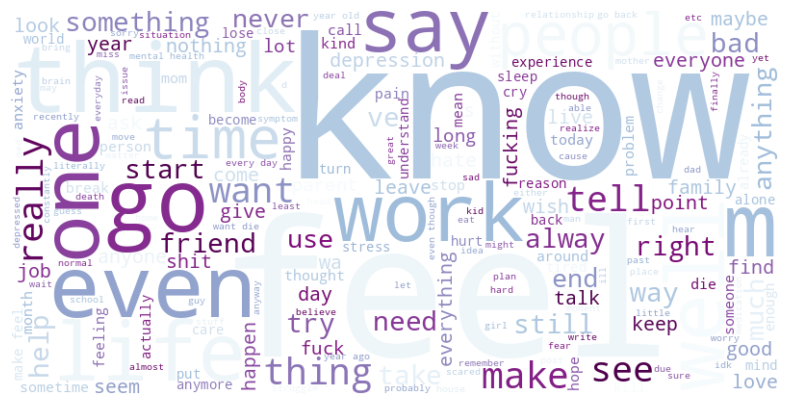

In [24]:
all_text = ' '.join(X_train['statement'])
plot_wordcloud(all_text)

In [25]:
y.unique().tolist()

[0, 1, 2, 3, 4, 5, 6]

In [26]:
def count_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
    """
    Vectorizes text data using CountVectorizer, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for CountVectorizer
    - max_features: Maximum number of features for CountVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - stop_words: List of stop words to be removed during vectorization
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.

    Example usage:
    ```
    vec_pred(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
             stop_words=['english'], n_estimators=100, max_depth=10)
    ```

    """
    best_vectorizer = CountVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate)
    best_classifier.fit(X_train_vector, y_train)
    X_test_vector = best_vectorizer.transform(X_test[text_col])
    y_pred = best_classifier.predict(X_test_vector)
    print(classification_report(y_test, y_pred))

    cm = confusion_matrix(y_test, y_pred)
    class_labels = y.unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [27]:
def tfidf_vec_boost(model, text_col, max_df, max_features, ngram_range, n_estimators, max_depth=3, learning_rate=0.03, verbose = False):
    """
    Vectorizes text data using TfidfVectorizer, trains a classifier model, and evaluates its performance.

    Parameters:
    - model: Classifier model (e.g., XGBoostClassifier, LightGBMClassifier, CatBoostClassifier)
    - text_col: Name of the text column in the dataset
    - max_df: Maximum document frequency threshold for TfidfVectorizer
    - max_features: Maximum number of features for TfidfVectorizer
    - ngram_range: Tuple specifying the range of n-grams (e.g., (1, 2) for unigrams and bigrams)
    - stop_words: List of stop words to be removed during vectorization
    - n_estimators: Number of estimators for the classifier model
    - max_depth: Maximum depth of the decision trees (if applicable)
    - learning_rate: Learning rate for gradient boosting classifiers (if applicable)

    Returns:
    - None

    Prints:
    - Classification report showing precision, recall, and F1-score for each class.
    - Confusion matrix visualizing predicted vs. true labels.

    Example usage:
    ```
    vec_boost_tfidf(RandomForestClassifier, 'text_column', max_df=0.8, max_features=1000, ngram_range=(1, 2),
                    stop_words=['english'], n_estimators=100, max_depth=10)
    ```
    """
    # Vectorize text data using TfidfVectorizer
    best_vectorizer = TfidfVectorizer(max_df=max_df, max_features=max_features, ngram_range=ngram_range)
    X_train_vector = best_vectorizer.fit_transform(X_train[text_col])

    # Initialize and train the classifier model
    best_classifier = model(n_estimators=n_estimators, max_depth=max_depth, learning_rate=learning_rate, verbose = verbose)
    best_classifier.fit(X_train_vector, y_train)

    # Transform test data using the trained vectorizer
    X_test_vector = best_vectorizer.transform(X_test[text_col])

    # Predict test labels
    y_pred = best_classifier.predict(X_test_vector)

    # Print classification report
    print(classification_report(y_test, y_pred))

    # Compute and plot confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    class_labels = y_test.unique().tolist()
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, cmap='Blues', fmt='d', xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.title('Confusion Matrix')
    plt.show()

In [28]:
def pipe_boosting(vectorizer, classifier, X_grid, y_grid):
    pipeline = Pipeline([
        ('vectorizer', vectorizer),
        ('classifier', classifier)
    ])

    hyperparameters = {
        'vectorizer__ngram_range': [(1, 3)],
        'vectorizer__max_df': [1.0],
        'classifier__n_estimators': [100, 200],
        'classifier__learning_rate':[0.01, 0.02, 0.03, 0.04, 0.05, 0.06, 0.07]}

    grid_search = GridSearchCV(pipeline, hyperparameters, cv=5, n_jobs=-1, verbose=1)

    grid_search.fit(X_grid, y_grid)

    print("Best hyperparameters:", grid_search.best_params_)

In [29]:
def predict_new_text(text, c_vectorizer, model):
    """
    Predicts the category of a given text using the trained vectorizer and model.

    Parameters:
    - text: The input text to be classified
    - c_vectorizer: The trained CountVectorizer or TfidfVectorizer
    - model: The trained classification model

    Returns:
    - dict: The predicted category label and its corresponding index
    """
    # Define the mapping of indices to category labels
    label_mapping = {
        0: 'Anxiety',
        1: 'Normal',
        2: 'Depression',
        3: 'Suicidal',
        4: 'Stress',
        5: 'Bipolar',
        6: 'Personality disorder'
    }

    # Transform the input text using the vectorizer
    text_vector = c_vectorizer.transform([text])

    # Predict the category index
    predicted_index = model.predict(text_vector)[0]

    # Map the predicted index to the category label
    predicted_label = label_mapping[predicted_index]

    return {predicted_label: predicted_index}

In [30]:
"""%%time
pipe_boosting(vectorizer = CountVectorizer(),
classifier = XGBClassifier(verbose = -1),
X_grid = X_train['statement'],
y_grid = y_train)"""

"%%time\npipe_boosting(vectorizer = CountVectorizer(),\nclassifier = XGBClassifier(verbose = -1),\nX_grid = X_train['statement'],\ny_grid = y_train)"

In [31]:
best_hyperparameters = {'learning_rate': 0.07, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 10000, 'ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.75      0.63      0.69       966
           1       0.75      0.96      0.84      4154
           2       0.70      0.68      0.69      3860
           3       0.66      0.58      0.62      2572
           4       0.69      0.38      0.49       697
           5       0.87      0.65      0.75       711
           6       0.90      0.42      0.57       301

    accuracy                           0.72     13261
   macro avg       0.76      0.62      0.66     13261
weighted avg       0.72      0.72      0.71     13261



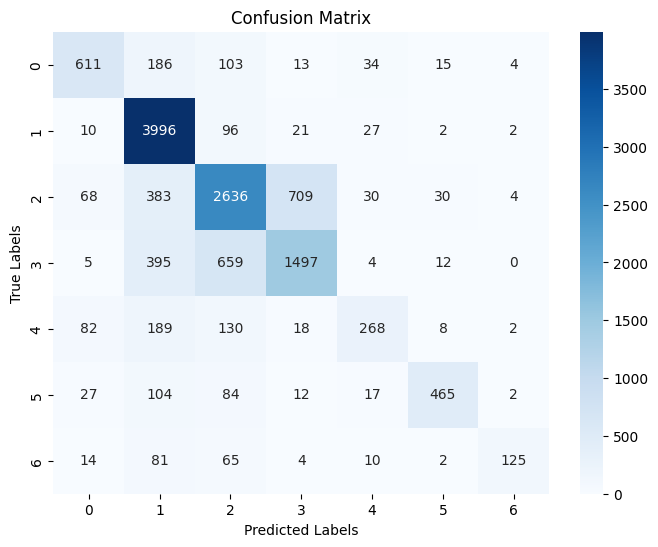

In [32]:
count_vec_boost(XGBClassifier, "statement", **best_hyperparameters, verbose = False)

In [33]:
c_vectorizer = CountVectorizer(max_df = 1.0, max_features = 2000, ngram_range = (1, 3))
X_train_vector = c_vectorizer.fit_transform(X_train['statement'])
X_test_vector = c_vectorizer.transform(X_test['statement'])

In [34]:
model = XGBClassifier(**best_hyperparameters)
model.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_df=1.0,
              max_features=10000, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, ...)

In [35]:
text = df["statement"].sample(1)
text_index = text.index
print(text.index)
text = text.values[0]
text

Index([14355], dtype='int64')


'right back get scare many opportunity kill never everything keep get worse bad every year wish gun would shoot right right turn go get gun kill one year dead finally wish hung'

In [36]:
predict_new_text(text,c_vectorizer, model)

{'Suicidal': 3}

In [37]:
df.loc[text_index]["status"]

,status
14355,3


              precision    recall  f1-score   support

           0       0.79      0.72      0.75       966
           1       0.80      0.95      0.87      4154
           2       0.71      0.70      0.71      3860
           3       0.66      0.62      0.64      2572
           4       0.65      0.47      0.55       697
           5       0.86      0.69      0.77       711
           6       0.86      0.45      0.59       301

    accuracy                           0.75     13261
   macro avg       0.76      0.66      0.70     13261
weighted avg       0.74      0.75      0.74     13261



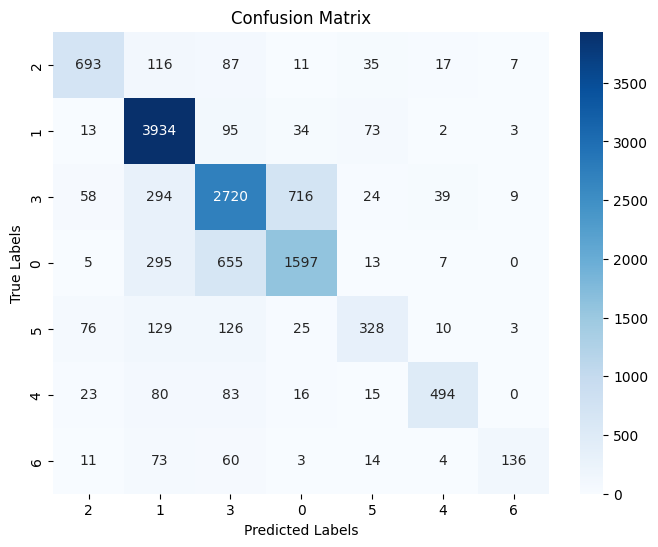

In [38]:
tfidf_vec_boost(XGBClassifier, "statement", 1.0, 2000, (1, 3), 200, 5, 0.07, verbose = False)

In [39]:
"""%%time
pipe_boosting(vectorizer = TfidfVectorizer(),
classifier = LGBMClassifier(force_col_wise=True, verbose = -1),
X_grid = X_train['statement'],
y_grid = y_train)"""

"%%time\npipe_boosting(vectorizer = TfidfVectorizer(),\nclassifier = LGBMClassifier(force_col_wise=True, verbose = -1),\nX_grid = X_train['statement'],\ny_grid = y_train)"

In [40]:
best_params = {'learning_rate': 0.06, 'n_estimators': 200, 'max_df': 1.0, 'max_features': 2000, 'ngram_range': (1, 3)}

              precision    recall  f1-score   support

           0       0.78      0.70      0.74       966
           1       0.78      0.96      0.86      4154
           2       0.71      0.70      0.70      3860
           3       0.67      0.60      0.63      2572
           4       0.67      0.45      0.54       697
           5       0.85      0.67      0.75       711
           6       0.85      0.44      0.58       301

    accuracy                           0.74     13261
   macro avg       0.76      0.64      0.69     13261
weighted avg       0.74      0.74      0.73     13261



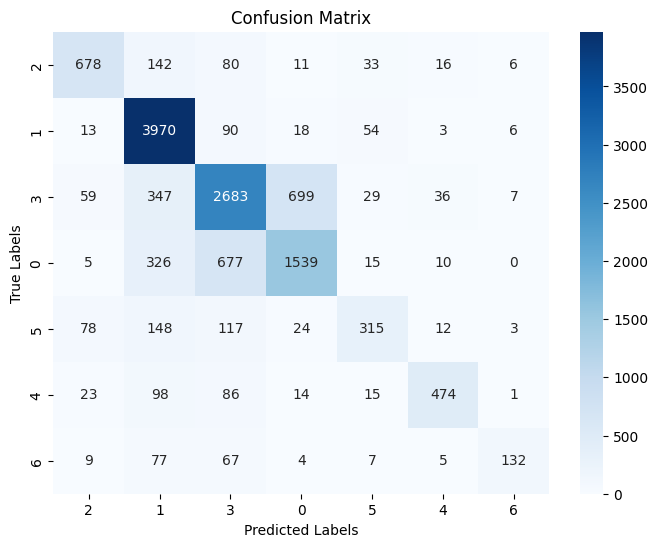

In [41]:
tfidf_vec_boost(LGBMClassifier, "statement", **best_params, verbose = -1)

In [42]:
model = XGBClassifier(**best_hyperparameters, verbose = False)
model.fit(X_train_vector, y_train)

XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.07, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=None, max_df=1.0,
              max_features=10000, max_leaves=None, min_child_weight=None,
              missing=nan, monotone_constraints=None, multi_strategy=None,
              n_estimators=200, n_jobs=None, ...)

In [43]:
"""text = df["statement"].sample(1)
text_index = text.index
print(text.index)
text = text.values[0]
text"""

'text = df["statement"].sample(1)\ntext_index = text.index\nprint(text.index)\ntext = text.values[0]\ntext'

In [44]:
predict_new_text(text, c_vectorizer, model)

{'Suicidal': 3}

In [45]:
df.loc[text_index]["status"]

,status
14355,3


In [46]:
import joblib

# Save the model to a file
joblib.dump(model, 'xgb_model.pkl')

['xgb_model.pkl']

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Define and fit your vectorizer on training data (if not already done)
vectorizer = TfidfVectorizer(max_features=2000)  # Adjust max_features as needed
X_train_vectorized = vectorizer.fit_transform(X_train)

# Save the vectorizer for later use
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [48]:
# Load your trained model and vectorizer
model = joblib.load('xgb_model.pkl')
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [49]:
# Custom text for analysis
custom_text = ["I feel anxious and overwhelmed lately."]

# Preprocess and transform using the fitted vectorizer
custom_text_cleaned = [text.lower() for text in custom_text]  # Simple cleaning step

# Transforming using the fitted vectorizer
custom_text_vectorized = vectorizer.transform(custom_text_cleaned)

# Check the shape of the transformed data
print("Shape of custom_text_vectorized:", custom_text_vectorized.shape)
print("Number of features in vectorizer:", len(vectorizer.get_feature_names_out()))
print("Expected number of features by model:", model.n_features_in_)
print("Shape of custom_text_vectorized:", custom_text_vectorized.shape)

Shape of custom_text_vectorized: (1, 1)
Number of features in vectorizer: 1
Expected number of features by model: 2000
Shape of custom_text_vectorized: (1, 1)


In [50]:
# Make prediction
# prediction = model.predict(custom_text_vectorized)

# # Display the result
# print("Predicted Sentiment:", prediction)

ValueError: Feature shape mismatch, expected: 2000, got 1

In [51]:
from sklearn.feature_extraction.text import TfidfVectorizer
import joblib

# Assuming you have a DataFrame `df` with a column 'statement'
X = df['statement']  # Your input text data
y = df['status']     # Your target labels

# Create and fit the vectorizer on your training data
vectorizer = TfidfVectorizer(max_features=2000)  # Ensure max_features matches what your model expects
X_train_vectorized = vectorizer.fit_transform(X)

# Save the fitted vectorizer for later use
joblib.dump(vectorizer, 'tfidf_vectorizer.pkl')

['tfidf_vectorizer.pkl']

In [52]:
# Load your trained model and vectorizer
model = joblib.load('xgb_model.pkl')  # Adjust filename if necessary
vectorizer = joblib.load('tfidf_vectorizer.pkl')

In [53]:
# Custom text for analysis
custom_text = ["I feel angry"]

# Preprocess the custom text (simple cleaning step)
custom_text_cleaned = [text.lower() for text in custom_text]

# Transform using the fitted vectorizer
custom_text_vectorized = vectorizer.transform(custom_text_cleaned)

# Check the shape of the transformed data
print("Shape of custom_text_vectorized:", custom_text_vectorized.shape)
print("Number of features in vectorized custom text:", custom_text_vectorized.shape[1])

Shape of custom_text_vectorized: (1, 2000)
Number of features in vectorized custom text: 2000


In [54]:
# Make prediction
prediction = model.predict(custom_text_vectorized)

# Display the result
print("Predicted Sentiment:", prediction)

Predicted Sentiment: [1]


In [55]:
custom_texts = [
    "I feel anxious and overwhelmed lately.",
    "I'm feeling great and very happy!",
    "I can't sleep at night due to stress."
]

for text in custom_texts:
    cleaned_text = [text.lower()]
    vectorized_text = vectorizer.transform(cleaned_text)
    prediction = model.predict(vectorized_text)
    print(f"Text: '{text}' -> Predicted Sentiment: {prediction[0]}")

Text: 'I feel anxious and overwhelmed lately.' -> Predicted Sentiment: 1
Text: 'I'm feeling great and very happy!' -> Predicted Sentiment: 1
Text: 'I can't sleep at night due to stress.' -> Predicted Sentiment: 1


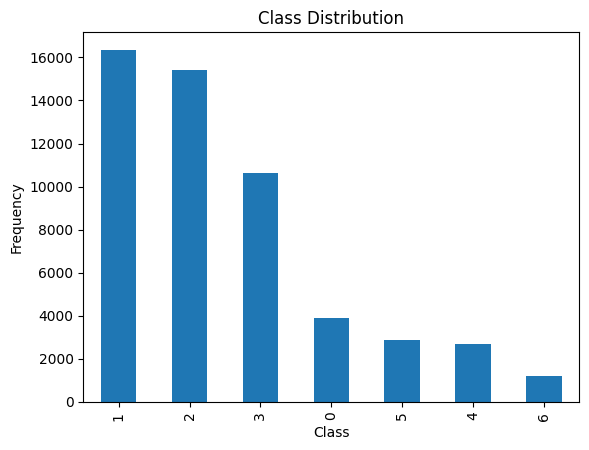

In [56]:
import matplotlib.pyplot as plt

# Assuming 'status' is your target variable
class_counts = df['status'].value_counts()
class_counts.plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Class')
plt.ylabel('Frequency')
plt.show()

In [57]:
# import pandas as pd
# from sklearn.model_selection import train_test_split
# from sklearn.metrics import classification_report
# from xgboost import XGBClassifier
# import joblib

# # Load your dataset
# df = pd.read_csv('/content/Combined Data.csv')

# # Assuming 'statement' is your feature and 'status' is your target
# X = df['statement']
# y = df['status']
# X = X.fillna('')
# # Split the data into training and testing sets
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# # Vectorization (assuming you've already fitted a vectorizer)
# vectorizer = TfidfVectorizer(max_features=2000)
# X_train_vectorized = vectorizer.fit_transform(X_train)
# X_test_vectorized = vectorizer.transform(X_test)

# # Train your model (if not already trained)
# model = joblib.load('xgb_model.pkl')
# model.fit(X_train_vectorized, y_train)

# # Make predictions on the test set
# y_pred = model.predict(X_test_vectorized)

# # Generate and print classification report
# print(classification_report(y_test, y_pred))

ValueError: Invalid classes inferred from unique values of `y`.  Expected: [0 1 2 3 4 5 6], got ['Anxiety' 'Bipolar' 'Depression' 'Normal' 'Personality disorder' 'Stress'
 'Suicidal']

In [58]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from xgboost import XGBClassifier
from sklearn.preprocessing import LabelEncoder
import joblib
from sklearn.feature_extraction.text import TfidfVectorizer


# Load your dataset
df = pd.read_csv('/content/Combined Data.csv')

# Assuming 'statement' is your feature and 'status' is your target
X = df['statement']
y = df['status']
X = X.fillna('')

# Convert string labels in 'y' to numerical labels using LabelEncoder
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(y) # Fit and transform the target variable 'y' to numerical labels

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Vectorization (assuming you've already fitted a vectorizer)
vectorizer = TfidfVectorizer(max_features=2000)
X_train_vectorized = vectorizer.fit_transform(X_train)
X_test_vectorized = vectorizer.transform(X_test)

# Train your model (if not already trained)
#model = joblib.load('xgb_model.pkl') # Commenting out to train a new model with numerical labels.
model = XGBClassifier() # Initializing a new model
model.fit(X_train_vectorized, y_train) # Fitting with numerical labels


# Make predictions on the test set
y_pred = model.predict(X_test_vectorized)

# Generate and print classification report
print(classification_report(y_test, y_pred))

              precision    recall  f1-score   support

           0       0.81      0.79      0.80       779
           1       0.88      0.72      0.79       580
           2       0.71      0.73      0.72      3100
           3       0.86      0.95      0.90      3327
           4       0.94      0.48      0.64       248
           5       0.73      0.52      0.61       557
           6       0.68      0.66      0.67      2018

    accuracy                           0.77     10609
   macro avg       0.80      0.69      0.73     10609
weighted avg       0.77      0.77      0.77     10609

